In [47]:
import numpy as np
import ants
import matplotlib.pyplot as plt
import os
from antspynet.utilities import brain_extraction
import logging
import gc
import nibabel as nib
import reorient_nii

In [48]:
# Configuração do logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

def porcentagem_limiar(values, thresh): #vê qual o porcentagem de valores acima de um threshold
    if len(values.shape) > 1:
        values = values.flatten()

    thresh_count = 0
    
    for value in values:
        if value > thresh:
            thresh_count += 1

    print(f"TOTAL VOXELS: {len(values)} \nMAIOR QUE {thresh}: {thresh_count} \nrazão: {(thresh_count/len(values))*100:.2f}%")

def metricas_imagem(data): #print metricas de uma imagem (max, min, media)
    if len(data.shape) > 1:
        values = data.flatten()

    print(f"MEDIA: {np.mean(values)}")
    print(f"MIN: {np.min(values)}")
    print(f"MAX: {np.max(values)}")

    plt.hist(values)
    plt.show()

def winsorize_image(image_data, lower_percentile=0, upper_percentile=99.9): #reduz valores extremos
    lower_bound = np.percentile(image_data, lower_percentile)
    upper_bound = np.percentile(image_data, upper_percentile)
    winsorized_data = np.clip(image_data, lower_bound, upper_bound)
    return winsorized_data

def normalize_image_min(image_data): #normalizar 
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    normalized_data = (image_data - min_val) / (max_val - min_val)
    return normalized_data

# Função para processar uma única imagem
def process_image(img_path, template, registro='Affine', orientation='false'):
    try:
        logger.info(f"Inicio processamento: {img_path}")
        # Carrega a imagem
        image = ants.image_read(img_path,reorient=orientation)

        # Registra pra padronizar shape da imagem
        registration = ants.registration(fixed=template, moving=image, type_of_transform=registro)
        affine_image = registration['warpedmovout']
        brain_masked = affine_image

        # Cria template pra máscara
        # prob_mask = brain_extraction(affine_image, modality='t1')
        # logger.info(f"Template obtido.")

        # # Cria a máscara
        # mask = ants.get_mask(prob_mask, low_thresh=0.5)
        # logger.info(f"Máscara aplicada.")

        # # Máscara do cérebro e extração
        # brain_masked = ants.mask_image(affine_image, mask)
        # logger.info(f"Extração.")

        # Bias Field Correction
        #image = ants.from_numpy(data, origin=image.origin, spacing=image.spacing, direction=image.direction)
        image = ants.n4_bias_field_correction(brain_masked, shrink_factor=2)
        data = image.numpy()
        logger.info(f"Bias Corrigido.")

        # Winsorizing
        data = winsorize_image(data, 0, 99.9)
        logger.info(f"Winsorized.")

        # Normalização
        data = normalize_image_min(data)
        image = ants.from_numpy(data, origin=brain_masked.origin, spacing=brain_masked.spacing, direction=brain_masked.direction)

        logger.info(f"Imagem {img_path} processada.")

        #ants.image_write(image, output_path)
        #logger.info(f"Imagem salva: {os.path.basename(output_path)}")

        gc.collect()

        return image
        
    except Exception as e:
        logger.error(f"Erro ao processar a imagem {img_path}: {e}")
        return None
    
def plot_views(image):
    fig, axs = plt.subplots(1, 3)

    axs[0].imshow(image[80, :, :], cmap='grey')
    axs[0].set_title("esperado: sagital")
    axs[1].imshow(image[:, 80, :], cmap='grey')
    axs[1].set_title("esperado: coronal")
    axs[2].imshow(image[:, :, 80], cmap='grey')
    axs[2].set_title("esperado: axial")
    fig.tight_layout(rect=[0, 0, 1, 0.8])
    plt.show()

In [49]:
dir_oasis = '/mnt/c/Users/Paulo Pires/Desktop/Alzheimer_cnn/OASIS-1/OASIS_RAW/0.0'
dir = '/mnt/c/Users/Paulo Pires/Desktop/Alzheimer_cnn'
# proc_dir = "/mnt/c/Users/Paulo Pires/Desktop/Alzheimer_cnn/to_process/NIFTI_PROCESSED"
proc_dir = "/mnt/c/Users/Paulo Pires/Desktop/Alzheimer_cnn/OASIS-1/OASIS_RAW_PROCESSED/0.0"

path = f"/mnt/c/Users/Paulo Pires/Desktop/Alzheimer_cnn/OASIS-1/RAW Data/disc1/OAS1_0001_MR1/RAW/OAS1_0001_MR1_mpr-1_anon.img"
proc_path = f"{proc_dir}/OAS1_0001_MR1_mpr-1_anon.nii.gz"

template_path = f"{dir}/Alzheimer-CNN-Detection/pre_processing/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c.nii"
template = ants.image_read(template_path)
mask_path = f"{dir}/Alzheimer-CNN-Detection/pre_processing/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_mask.nii"
mask = ants.image_read(mask_path)

In [50]:
orientations = [
    'RAS', 'RAI', 'RPS', 'RPI', 'LAS', 'LAI', 'LPS', 'LPI',
    'RSA', 'RSP', 'RIA', 'RIP', 'LSA', 'LSP', 'LIA', 'LIP',
    'ARS', 'ARI', 'PRS', 'PRI', 'ALS', 'ALI', 'PLS', 'PLI',
    'ASR', 'ASL', 'AIR', 'AIL', 'PSR', 'PSL', 'PIR', 'PIL',
    'SRA', 'SRP', 'IRA', 'IRP', 'SLA', 'SLP', 'ILA', 'ILP',
    'SAR', 'SAL', 'SPR', 'SPL', 'IAR', 'IAL', 'IPR', 'IPL'
]

In [51]:
possible_orientations = [
    'SRA', 'IRA'
]

NiftiImageIO (0x46dd9960): /mnt/c/Users/Paulo Pires/Desktop/Alzheimer_cnn/OASIS-1/RAW Data/disc1/OAS1_0001_MR1/RAW/OAS1_0001_MR1_mpr-1_anon.img is Analyze file and it's deprecated 

NiftiImageIO (0x42884250): /mnt/c/Users/Paulo Pires/Desktop/Alzheimer_cnn/OASIS-1/RAW Data/disc1/OAS1_0001_MR1/RAW/OAS1_0001_MR1_mpr-1_anon.img is Analyze file and it's deprecated 



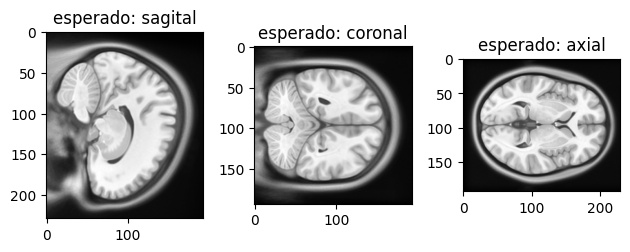

SRA


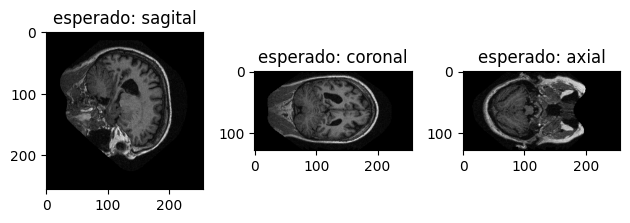

IRA


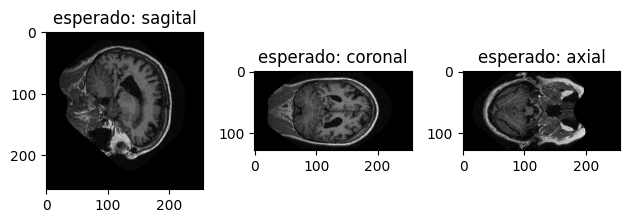

In [53]:
img = ants.image_read(path, reorient='SRA')
img_data = img.numpy()

plot_views(template.numpy())

for orint in possible_orientations:
    print(orint)

    img_reori = ants.reorient_image2(img, orientation=orint)

    plot_views(img_reori.numpy())

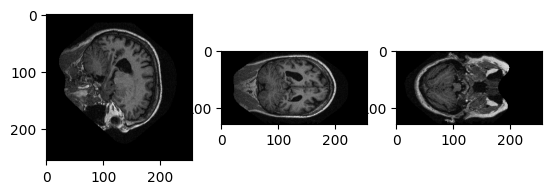

In [54]:
fig, axs = plt.subplots(1,3)

axs[0].imshow(img_data[80, :, :], cmap='gray')
axs[1].imshow(img_data[:, 80, :], cmap='gray')
axs[2].imshow(img_data[:, :, 80], cmap='gray')

plt.show()

In [ ]:
# Registra pra padronizar shape da imagem
registration = ants.registration(fixed=template, moving=img, type_of_transform='Affine')
affine_img = registration['warpedmovout']

very large origin values relative to dims; leaving as set, ignoring for affine
2025-09-24 17:17:48,781 - INFO - very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
2025-09-24 17:17:48,783 - INFO - very large origin values relative to dims; leaving as set, ignoring for affine
very large origin values relative to dims; leaving as set, ignoring for affine
2025-09-24 17:17:48,787 - INFO - very large origin values relative to dims; leaving as set, ignoring for affine


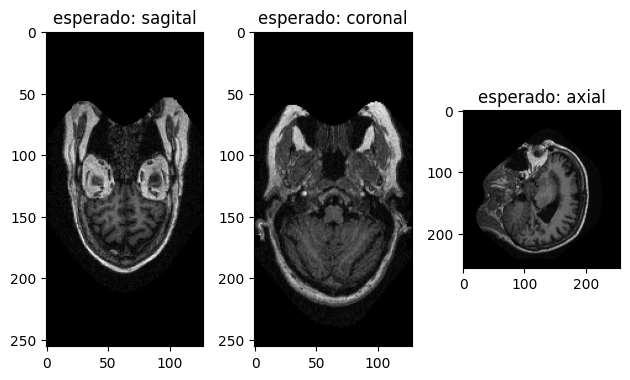

very large origin values relative to dims; leaving as set, ignoring for affine
2025-09-24 17:17:49,141 - INFO - very large origin values relative to dims; leaving as set, ignoring for affine


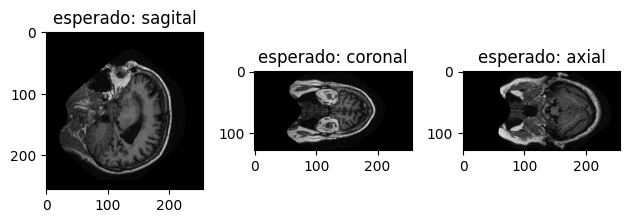

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
2025-09-24 17:17:49,416 - INFO - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [60]:
nii_img = reorient_nii.load(path)

plot_views(nii_img.get_fdata())

nii_reoriented = reorient_nii.reorient(nii_img, orientation='SRA')

plot_views(nii_reoriented.get_fdata())

nib.save(nii_reoriented, 'oasis_testing.nii.gz')

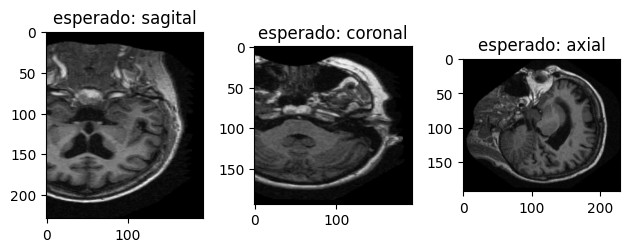

In [61]:
nii_img = ants.image_read('oasis_testing.nii.gz')

registration = ants.registration(fixed=template, moving=nii_img, type_of_transform='Affine')
affine_nii = registration['warpedmovout']

plot_views(affine_nii.numpy())

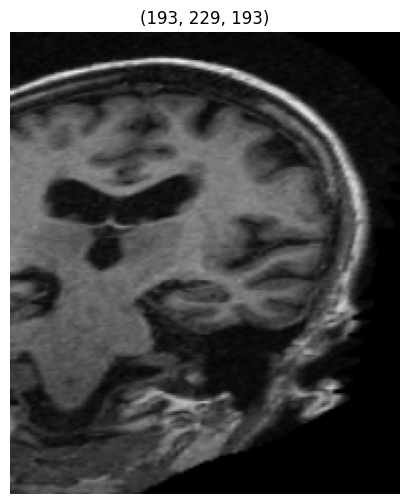

In [42]:
plt.figure(figsize=(8, 6))
plt.imshow(affine_img.numpy()[100, :, :], cmap='gray')
plt.title(affine_img.shape)
plt.axis('off')
plt.show()

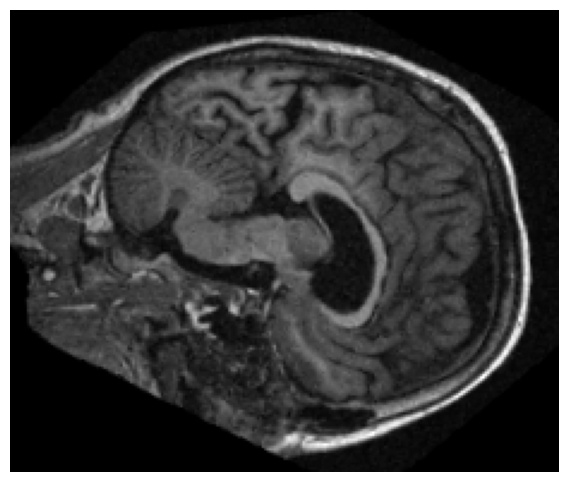

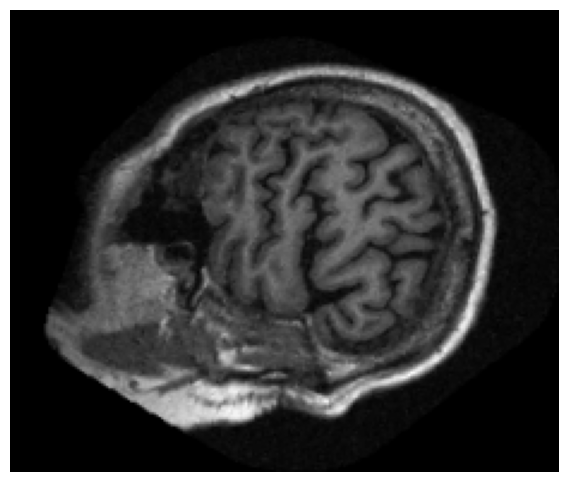

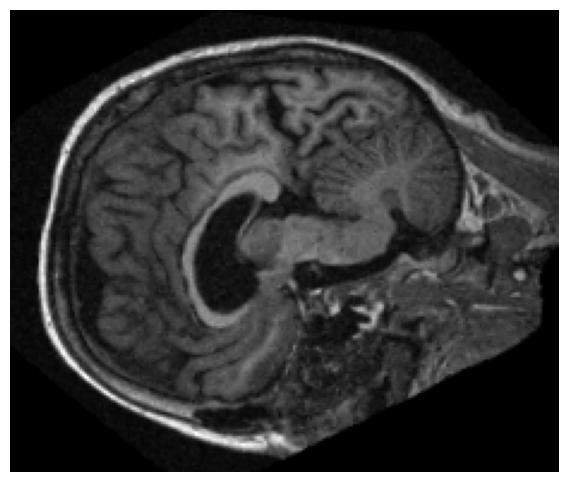

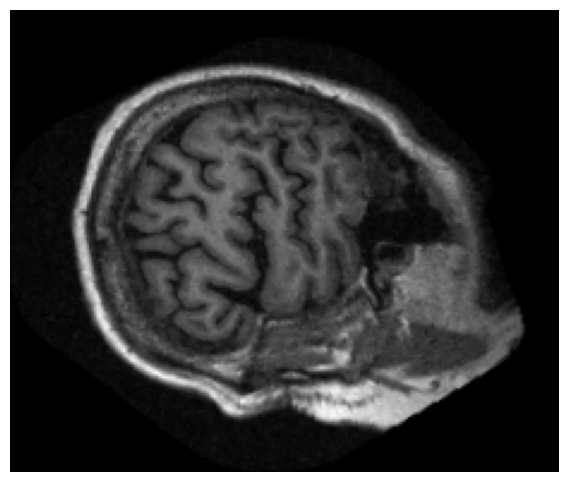

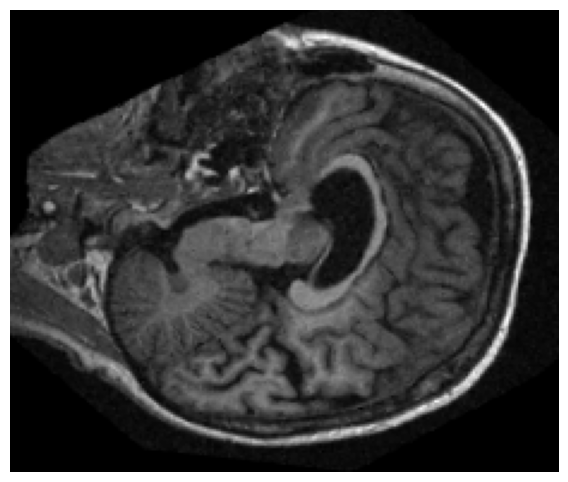

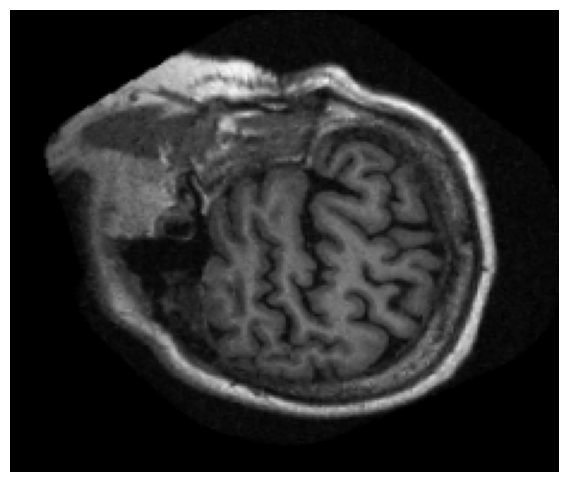

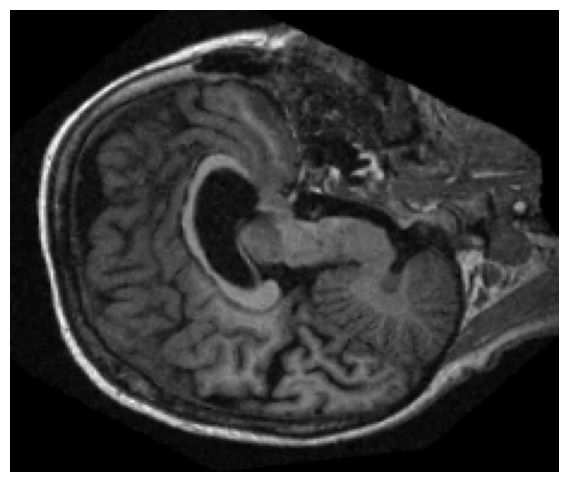

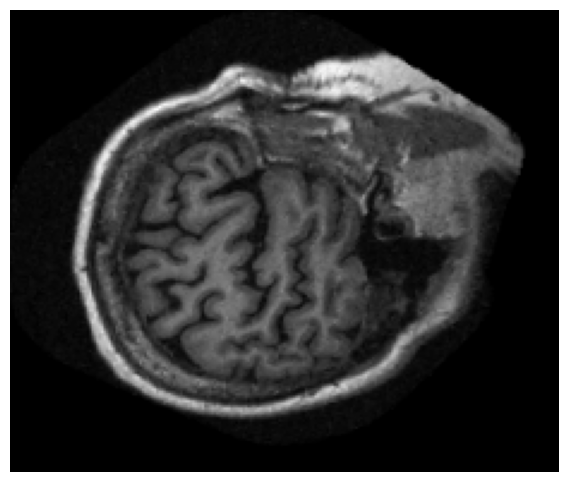

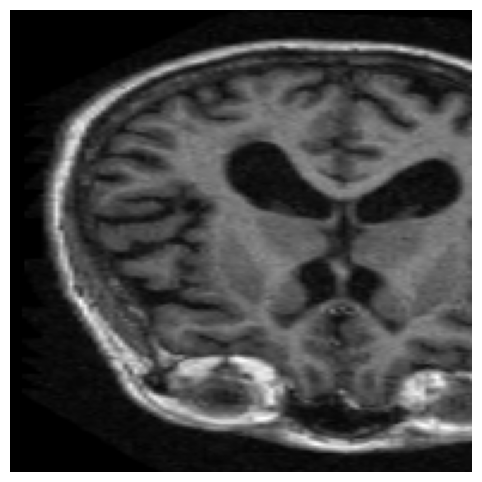

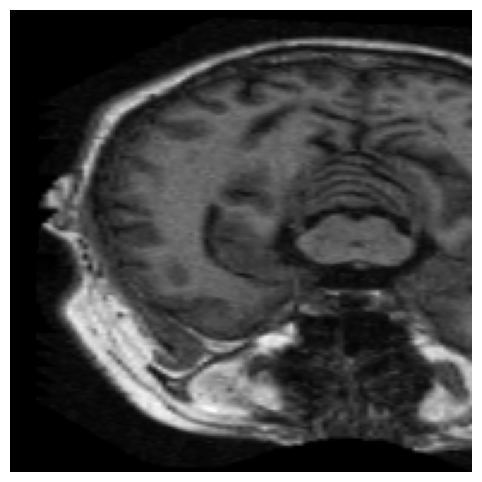

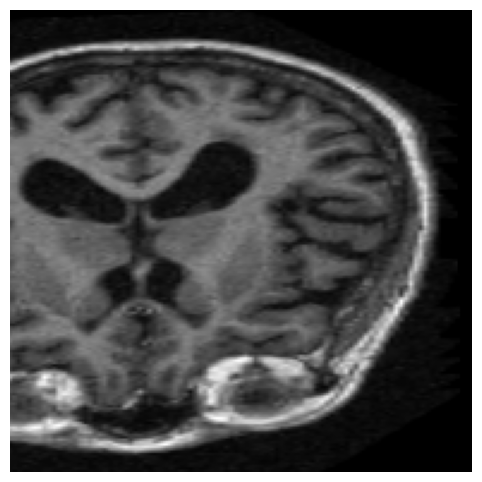

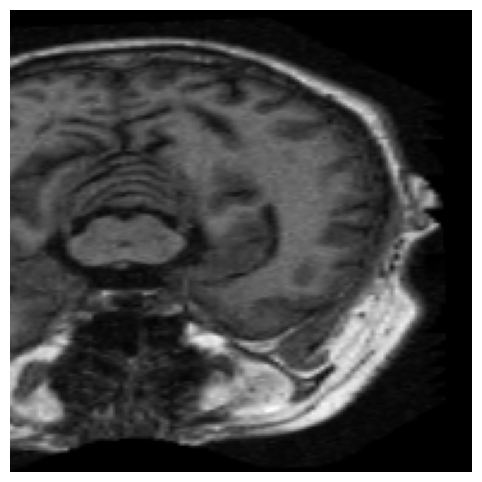

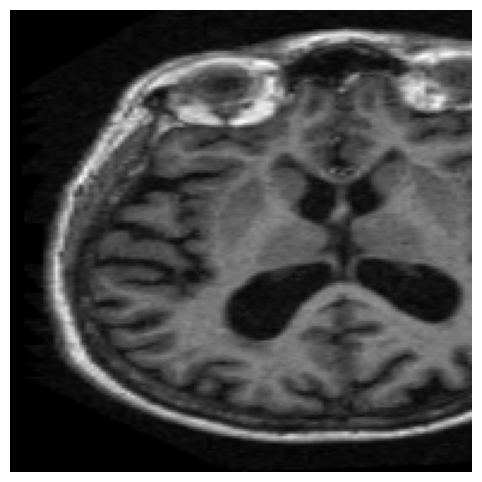

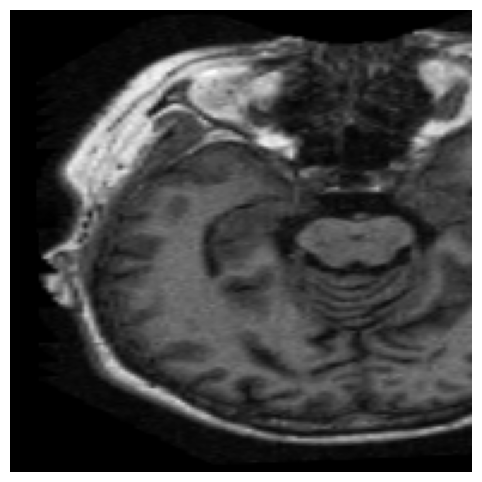

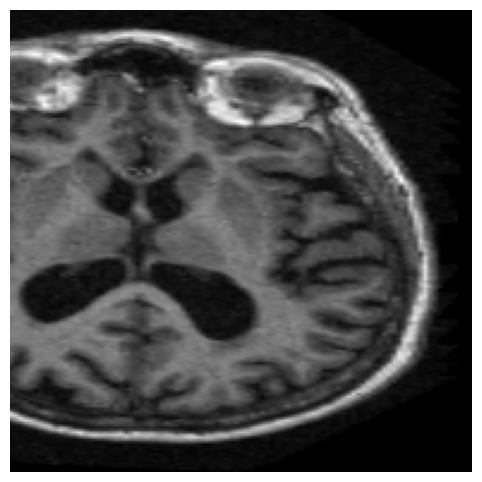

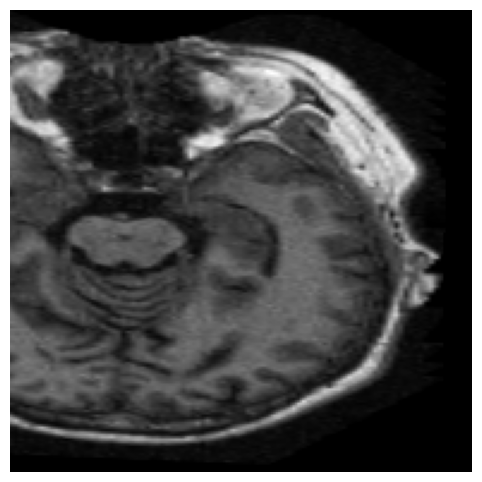

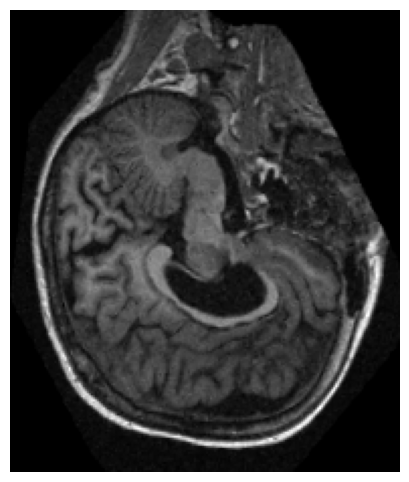

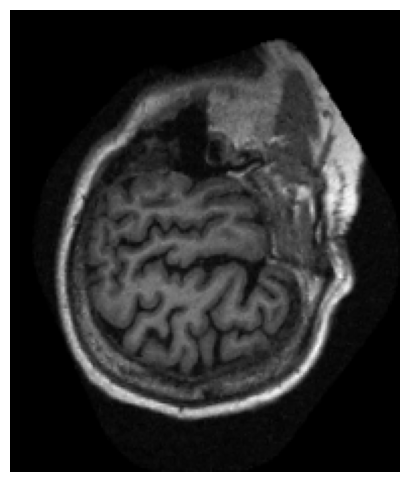

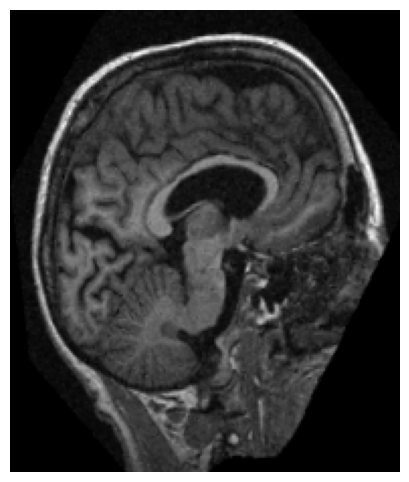

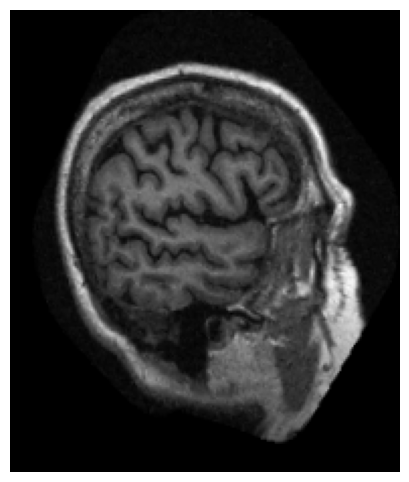

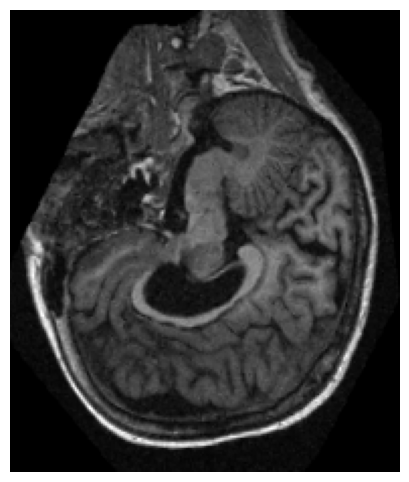

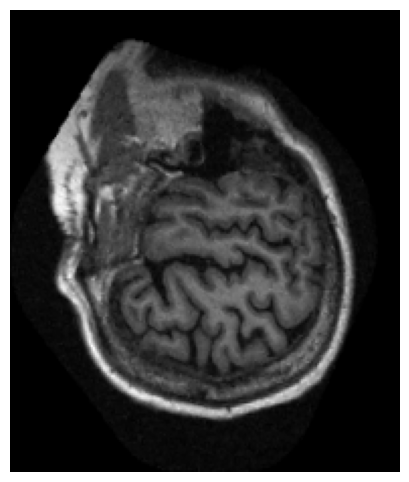

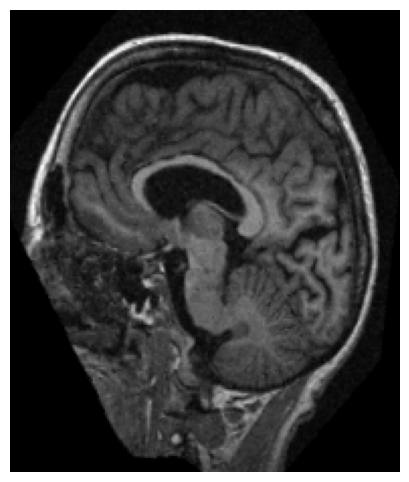

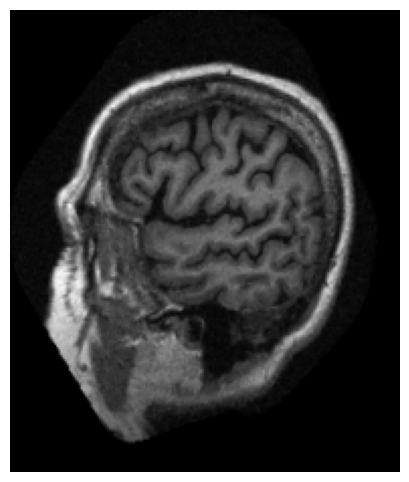

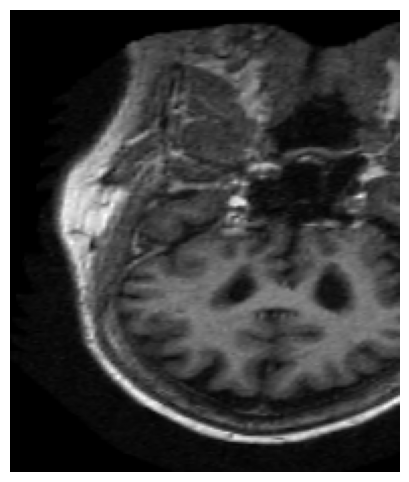

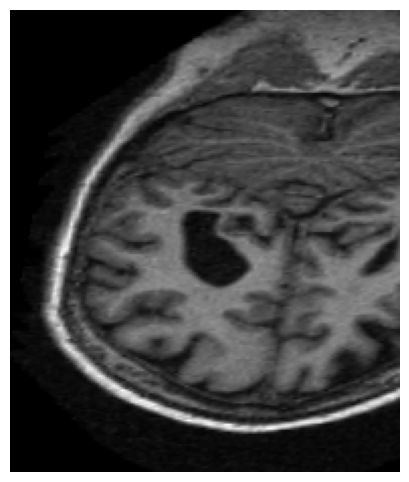

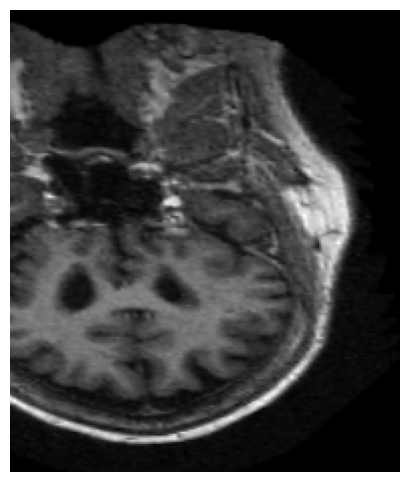

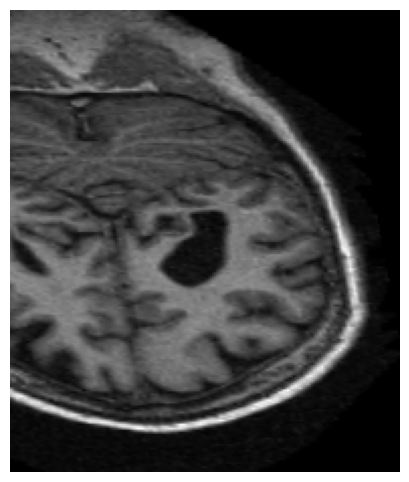

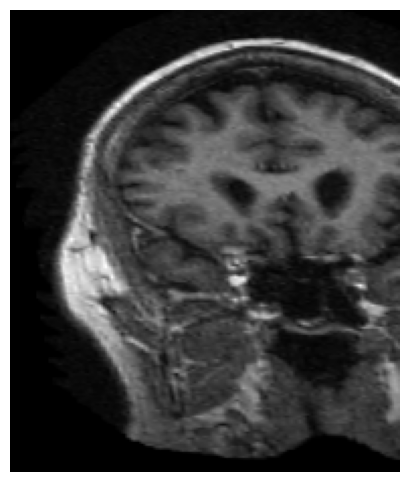

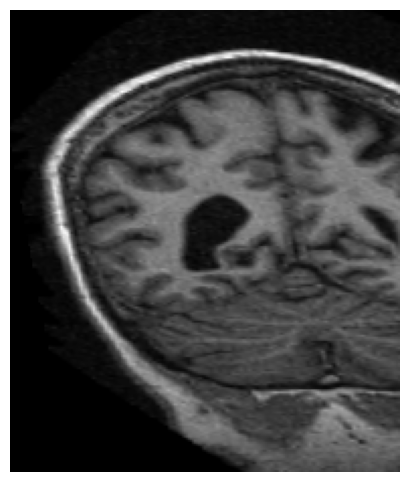

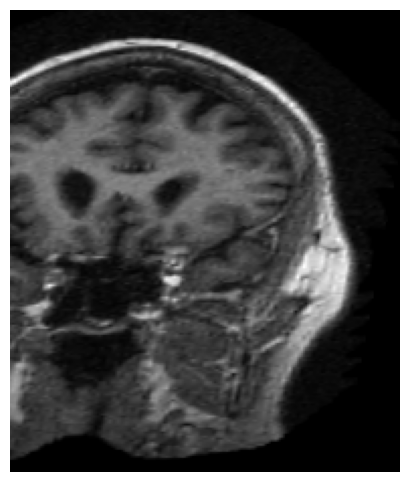

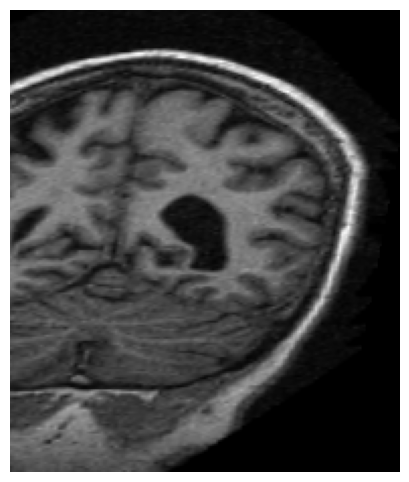

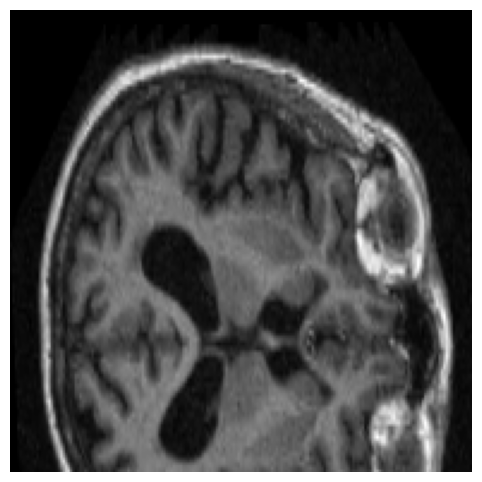

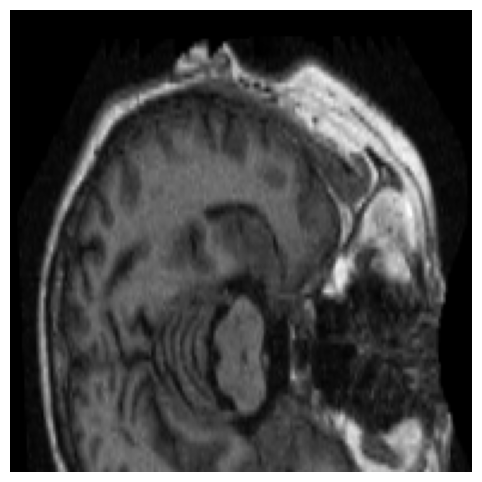

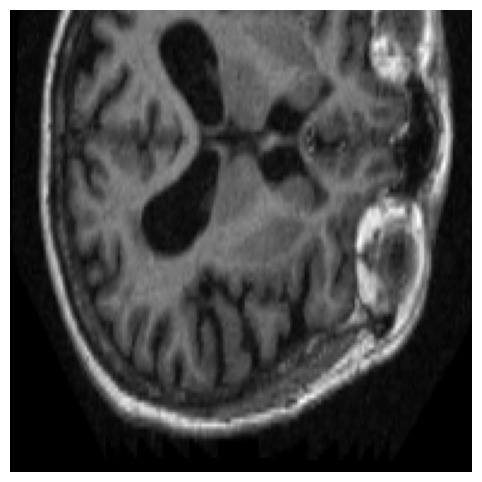

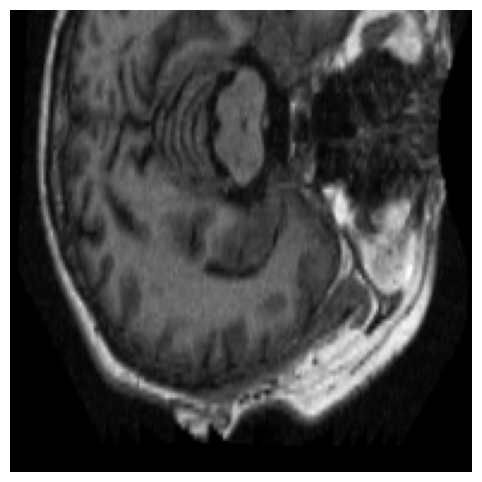

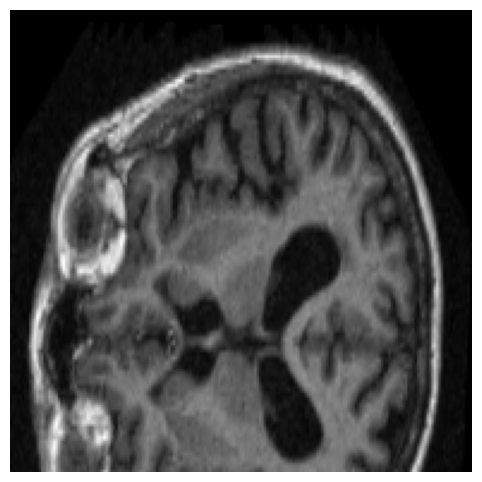

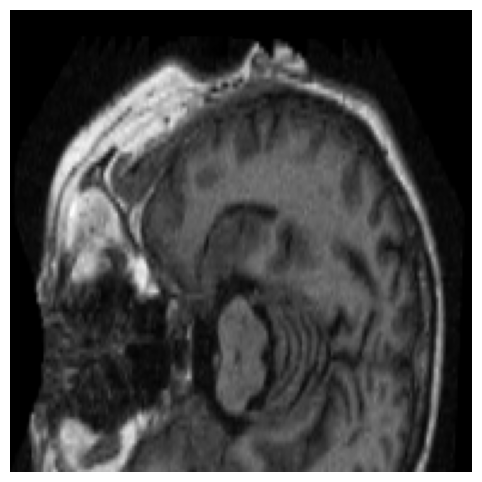

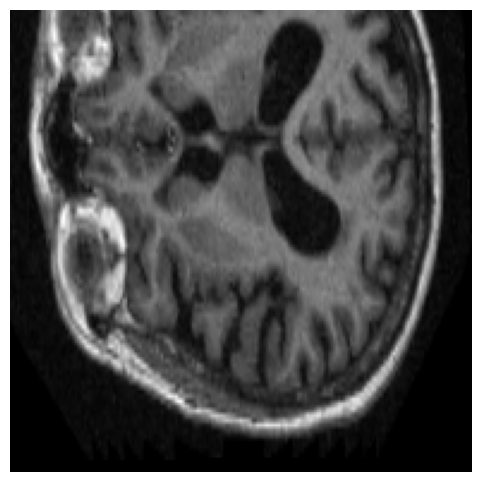

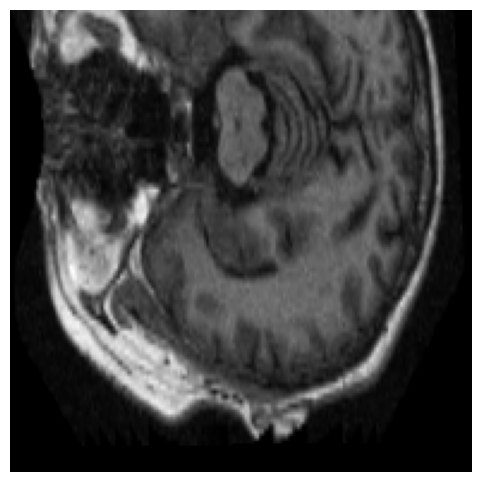

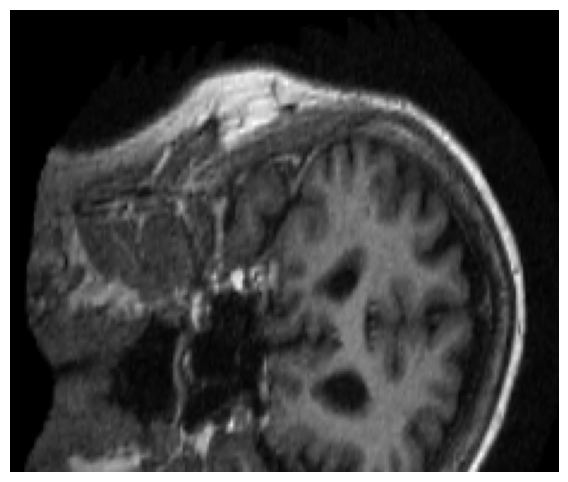

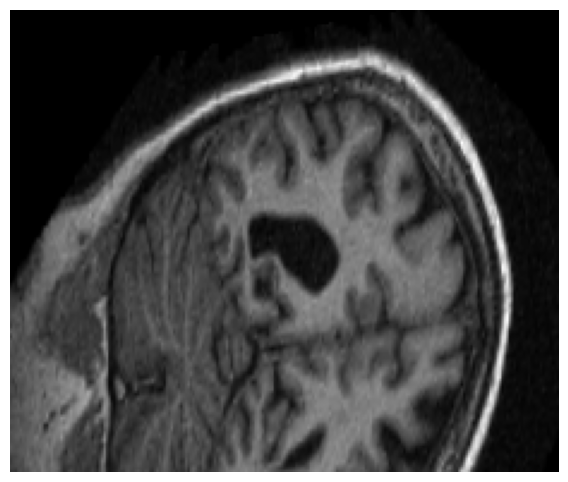

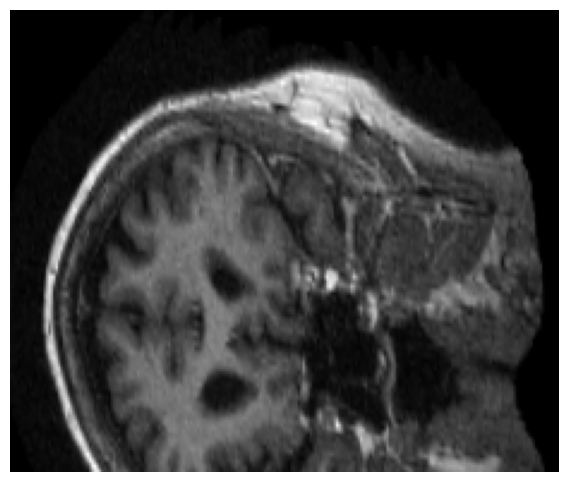

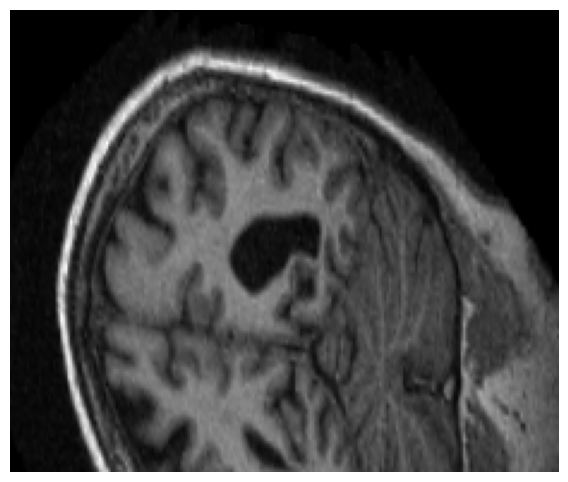

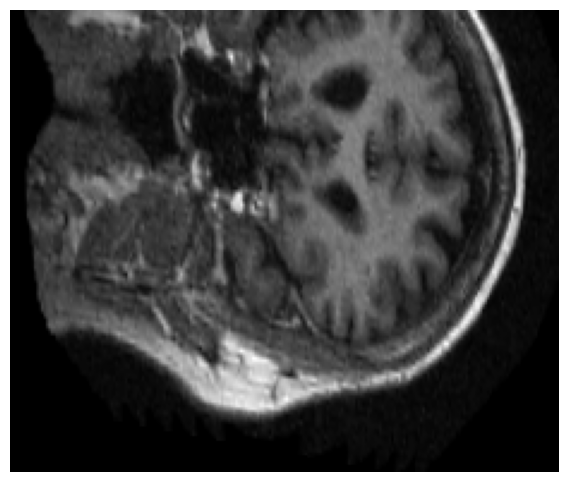

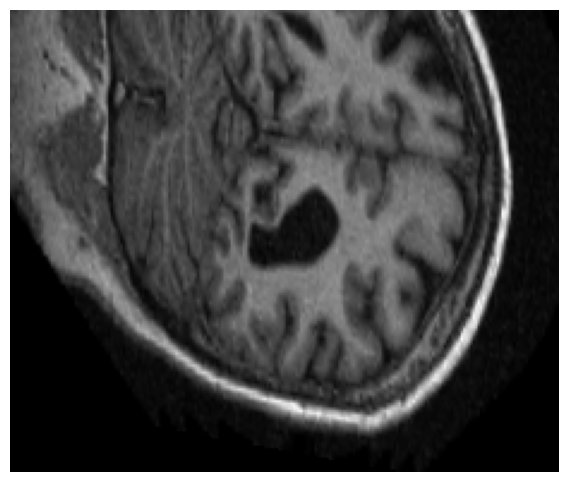

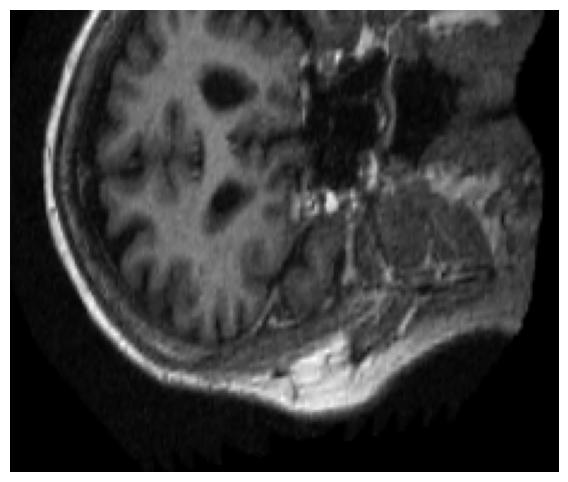

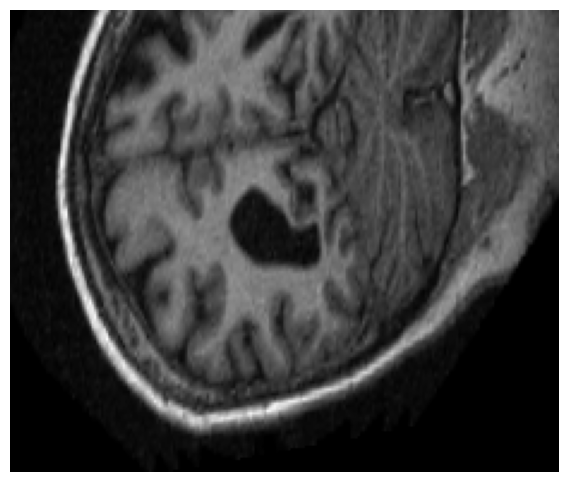

In [11]:
for orint in orientations:
    img_reori = ants.reorient_image2(affine_img, orientation=orint)

    plt.figure(figsize=(8, 6))
    plt.imshow(img_reori.numpy()[:, :, 130], cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
# translation
translation_image = process_image(path, template, 'Translation', 'IRA')

# translation
print('TRANSLATION')
for i in range(0, translation_image.shape[2], 10):
    plt.imshow(translation_image.numpy()[:, :, i], cmap='gray')
    plt.title(translation_image.shape)
    plt.show()

In [ ]:
# rigid
rigid_image = process_image(path, template, 'Rigid')

# rigid
print('RIGID')
for i in range(0, translation_image.shape[2], 10):
    plt.imshow(rigid_image.numpy()[:, :, i], cmap='gray')
    plt.title(rigid_image.shape)
    plt.show()

In [ ]:
#affine
affine_image = process_image(path, template, 'Affine')

#affine
print('AFFINE')
for i in range(0, translation_image.shape[2], 10):
    plt.imshow(affine_image.numpy()[:, :, i], cmap='gray')
    plt.title(affine_image.shape)
    plt.show()

In [ ]:
# original
print('ORIGINAL')
for i in range(0, img_data.shape[2], 10):
    plt.imshow(img_data[:, :, i], cmap='gray')
    plt.title(img_data.shape)
    plt.show()

In [ ]:
# DADOS DA IMAGEM PURA NÃO PROCESSADA
metricas_imagem(img_data)
#porcentagem_limiar(img_data, 2300)

In [ ]:
# DADOS DA IMAGEM NORMALIZADA SEM WINSORIZATION
norm_sem_wins_data = normalize_image_min(img_data)
metricas_imagem(norm_sem_wins_data)

In [ ]:
# DADOS DA IMAGEM PURA WINSORIZADA
wins_data = winsorize_image(img_data, 0, 99.9)
metricas_imagem(wins_data)

In [ ]:
# DADOS DA IMAGEM WINSORIZADA E NORMALIZADA
norm_data = normalize_image_min(wins_data)
metricas_imagem(norm_data)

In [ ]:
dir = '/mnt/c/Users/Paulo Pires/Desktop/Alzheimer_cnn/to_process/NIFTI_RAW/test'

count = 0

for subset in os.listdir(dir):
    print("="*300)
    print(f"{subset}")
    print("="*300)
    
    count = 0
    names_path = f"{dir}/{subset}"
    names = os.listdir(names_path)

    for name in names:
        while count < 15:
            filepath = f"{names_path}/{name}"
            img = ants.image_read(filepath)
            img_data = img.numpy()

            metricas_imagem(img_data)

            count += 1

In [ ]:
count = 0

for subset in os.listdir(dir):
    print("="*300)
    print(f"{subset}")
    print("="*300)
    
    count = 0
    names_path = f"{dir}/{subset}"
    names = os.listdir(names_path)

    for name in names:
        if count < 15:
            filepath = f"{names_path}/{name}"
            img_for = ants.image_read(filepath)
            img_data_for = img_for.numpy()
            img_data_for = winsorize_image(img_data_for, 0, 99.9)

            metricas_imagem(img_data_for)

            count += 1

In [ ]:
plt.imshow(img_data[:, :, 133], cmap="gray")
plt.title(img_data.shape)
plt.show()

In [ ]:
plt.imshow(template.numpy()[:, :, 80], cmap="gray")
plt.title(template.shape)
plt.show()

#### Testando TRANSLATION na mri pura

In [ ]:
registration = ants.registration(fixed=template, moving=img, type_of_transform='Translation')
trans_image = registration['warpedmovout']

In [ ]:
plt.imshow(trans_image.numpy()[:, :, 80], cmap="gray")
plt.title(trans_image.shape)
plt.show()

#### Testando RIGID na mri pura

In [ ]:
registration = ants.registration(fixed=template, moving=img, type_of_transform='Rigid')
rigid_image = registration['warpedmovout']

In [ ]:
plt.imshow(rigid_image.numpy()[:, :, 80], cmap="gray")
plt.title(rigid_image.shape)
plt.show()

#### Testando AFFINE na mri pura

In [ ]:
registration = ants.registration(fixed=template, moving=img, type_of_transform='Affine')
affine_image = registration['warpedmovout']

In [ ]:
plt.imshow(affine_image.numpy()[:, :, 80], cmap="gray")
plt.imshow(mask.numpy()[:, :, 80], cmap='gray', alpha=0.0)
plt.title(affine_image.shape)
plt.show()

In [ ]:
prob_mask = brain_extraction(affine_image, modality='t1')

# Cria a máscara
mask = ants.get_mask(prob_mask, low_thresh=0.5)

# Máscara do cérebro e extração
brain_masked = ants.mask_image(affine_image, mask)

#### Testando SyN na mri pura

In [ ]:
registration = ants.registration(fixed=template, moving=img, type_of_transform='SyN')
syn_image = registration['warpedmovout']

In [ ]:
plt.imshow(syn_image.numpy()[:, :, 80], cmap="gray")
plt.imshow(mask.numpy()[:, :, 80], cmap='gray', alpha=0.25)
plt.title(syn_image.shape)
plt.show()

In [ ]:
affine_data = affine_image.numpy()
metricas_imagem(affine_data)

In [ ]:
affine_norm = winsorize_image(affine_data, 1, 99.9)
metricas_imagem(affine_norm)

In [ ]:
plt.imshow(affine_norm[:, :, 80], cmap='gray')
plt.show()

In [ ]:
dir = 'test_raw'

folders = os.listdir(dir)

for subset in folders:
    count = 0
    subset_path = f"{dir}/{subset}"

    names = os.listdir(subset_path)
    for name in names:
        while count < 1:
            name_path = f"{subset_path}/{name}"
            pre_data = ants.image_read(name_path)

            registration = ants.registration(fixed=template, moving=pre_data, type_of_transform='Rigid')
            rigid_data = registration['warpedmovout']

            # Cria template pra máscara
            prob_mask = brain_extraction(affine_data, modality='t1') # MODALIDADE: 'flair' ou 't1'

            # Cria a máscara
            mask = ants.get_mask(prob_mask, low_thresh=0.5)

            # Máscara do cérebro e extração
            brain_masked = ants.mask_image(affine_data, mask)

            wins_data = winsorize_image(affine_data.numpy(), 1, 99.9)

            norm_wins_data = normalize_image_min(wins_data)

            plt.imshow(norm_wins_data[:, :, 80], cmap='gray')
            plt.title(norm_wins_data.shape)
            plt.show()

            metricas_imagem(norm_wins_data)
            count += 1